<a href="https://colab.research.google.com/github/ensarakbas77/Match-Result-Prediction/blob/main/Autoformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from sklearn.metrics import roc_curve, auc, confusion_matrix
from itertools import cycle
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from torch import nn, Tensor
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
file_path= 'Matches.xlsx'
df=pd.read_excel(file_path)


# Sadece geçerli sonuçları tut
df = df[df['Sonuç'].isin([-1, 0, 1])]

# Haritalama işlemi
sonuc_mapping = {-1: 0, 0: 1, 1: 2}
df['Sonuç'] = df['Sonuç'].map(sonuc_mapping)

# **SEKANS & STATİK ÖZELLİKLER**

In [ ]:
# Takıma ve tarihe göre sırala
df = df.sort_values(by=['Takım ID', 'Tarih'])

# Boş değeri doldur
df["Şut Verimliliği"] = df["Şut Verimliliği"].fillna(df["Şut Verimliliği"].mean())

# Feature listeleri
sequence_features = [
    'Gol', 'Rakip Gol', 'Topla Oynama(%)', 'Şut', 'İsabetli Şut', 'Başarılı Pas',
    'Pas Başarısı(%)', 'Korner', 'Orta', 'Faul', 'Ofsayt',
    'Rakip Topla Oynama(%)', 'Rakip Şut', 'Rakip İsabetli Şut', 'Rakip Başarılı Pas',
    'Rakip Pas Başarısı(%)', 'Rakip Korner', 'Rakip Orta', 'Rakip Faul', 'Rakip Ofsayt'
]

static_features = [
    'Takım ID', 'Rakip Takım ID', 'Is_Home', 'Sezon', 'Ay', 'Haftanın Günü',
    'Şut Verimliliği', 'Son 5 Maç Gol Ort', 'Son 5 Maç Galibiyet Oranı'
]


feature_means = df[sequence_features].mean().values

def pad_sequence(seq, K, mean_vec):
    if len(seq) < K:
        padding = np.tile(mean_vec, (K - len(seq), 1))
        return np.vstack([padding, seq])
    return seq


K = 10
X_seq = []
X_static = []
y = []

for idx, row in df.iterrows():
    takim_id = row['Takım ID']
    rakip_id = row['Rakip Takım ID']
    tarih = row['Tarih']

    takim_gecmis = df[(df['Takım ID'] == takim_id) & (df['Tarih'] < tarih)].sort_values(by='Tarih').tail(K)

    rakip_gecmis = df[(df['Takım ID'] == rakip_id) & (df['Tarih'] < tarih)].sort_values(by='Tarih').tail(K)

    #if len(takim_gecmis) < 1 or len(rakip_gecmis) < 1:
        #continue

    takim_seq = pad_sequence(takim_gecmis[sequence_features].values, K, feature_means)
    rakip_seq = pad_sequence(rakip_gecmis[sequence_features].values, K, feature_means)

    full_seq = np.vstack([takim_seq, rakip_seq])

    static_vec = row[static_features].values.astype(np.float32)
    label = row['Sonuç']

    X_seq.append(full_seq)
    X_static.append(static_vec)
    y.append(label)


In [ ]:
X_seq = np.array(X_seq, dtype=np.float32)
X_static = np.array(X_static, dtype=np.float32)
y = np.array(y, dtype=np.int64)

print("X_seq shape     :", X_seq.shape)
print("X_static shape  :", X_static.shape)
print("y shape         :", y.shape)
print("Sınıf dağılımı  :", Counter(y))


X_seq shape     : (3734, 20, 20)
X_static shape  : (3734, 9)
y shape         : (3734,)
Sınıf dağılımı  : Counter({np.int64(2): 2241, np.int64(0): 788, np.int64(1): 705})


# **EĞİTİM & TEST AYRIMI**

In [ ]:
val_ratio = 0.15
test_ratio = 0.15

total_samples = len(X_seq)
test_size = int(total_samples * test_ratio)
val_size = int(total_samples * val_ratio)
train_size = total_samples - val_size - test_size

X_seq_train = X_seq[:train_size]
X_static_train = X_static[:train_size]
y_train = y[:train_size]

X_seq_val = X_seq[train_size:train_size + val_size]
X_static_val = X_static[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_seq_test = X_seq[-test_size:]
X_static_test = X_static[-test_size:]
y_test = y[-test_size:]


print("Train:", len(y_train), "Val:", len(y_val), "Test:", len(y_test))
print("Train Sınıf Dağılımı:", Counter(y_train))
print("Val   Sınıf Dağılımı:", Counter(y_val))
print("Test  Sınıf Dağılımı:", Counter(y_test))


Train: 2614 Val: 560 Test: 560
Train Sınıf Dağılımı: Counter({np.int64(2): 1604, np.int64(0): 512, np.int64(1): 498})
Val   Sınıf Dağılımı: Counter({np.int64(2): 338, np.int64(0): 121, np.int64(1): 101})
Test  Sınıf Dağılımı: Counter({np.int64(2): 299, np.int64(0): 155, np.int64(1): 106})


# **ENCODİNG & ÖLÇEKLEME**

In [ ]:
# 1. Tüm setleri DataFrame'e çevir
df_static_train = pd.DataFrame(X_static_train, columns=static_features)
df_static_val   = pd.DataFrame(X_static_val,   columns=static_features)
df_static_test  = pd.DataFrame(X_static_test,  columns=static_features)

# 2. Takım ve Rakip ID'leri ayır
takim_ids_train = df_static_train["Takım ID"].values.astype(np.int64)
rakip_ids_train = df_static_train["Rakip Takım ID"].values.astype(np.int64)

takim_ids_val = df_static_val["Takım ID"].values.astype(np.int64)
rakip_ids_val = df_static_val["Rakip Takım ID"].values.astype(np.int64)

takim_ids_test = df_static_test["Takım ID"].values.astype(np.int64)
rakip_ids_test = df_static_test["Rakip Takım ID"].values.astype(np.int64)

# 3. Encoding yapılacak sütunlar
categorical_ohe_cols = ['Sezon', 'Ay', 'Haftanın Günü']
numerical_cols = ['Is_Home', 'Şut Verimliliği', 'Son 5 Maç Gol Ort', 'Son 5 Maç Galibiyet Oranı']

# 4. One-Hot Encoder (sadece train'e fit et)
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(df_static_train[categorical_ohe_cols])

# 5. Encode edilmiş kategorik özellikler
ohe_train = ohe.transform(df_static_train[categorical_ohe_cols])
ohe_val   = ohe.transform(df_static_val[categorical_ohe_cols])
ohe_test  = ohe.transform(df_static_test[categorical_ohe_cols])

# 6. Numerik özellikler için StandardScaler (sadece train'e fit et)
scaler = StandardScaler()
scaler.fit(df_static_train[numerical_cols])

scaled_train = scaler.transform(df_static_train[numerical_cols])
scaled_val   = scaler.transform(df_static_val[numerical_cols])
scaled_test  = scaler.transform(df_static_test[numerical_cols])

# 7. Final encode edilmiş X_static verileri
X_static_train_encoded = np.hstack([ohe_train, scaled_train]).astype(np.float32)
X_static_val_encoded   = np.hstack([ohe_val, scaled_val]).astype(np.float32)
X_static_test_encoded  = np.hstack([ohe_test, scaled_test]).astype(np.float32)


# === SEKANS ÖZELLİKLERİ ===
# X_seq: (N, T=20, F=20)
N_train = X_seq_train.shape[0]
N_val   = X_seq_val.shape[0]
N_test  = X_seq_test.shape[0]
seq_len = X_seq_train.shape[1]
F       = X_seq_train.shape[2]

scaler_seq = StandardScaler()

# --- Train: fit + transform ---
X_seq_train_flat = X_seq_train.reshape(-1, F)  # (N*T, F)
X_seq_train_scaled_flat = scaler_seq.fit_transform(X_seq_train_flat)
X_seq_train_scaled = X_seq_train_scaled_flat.reshape(N_train, seq_len, F)

# --- Val: transform only ---
X_seq_val_flat = X_seq_val.reshape(-1, F)
X_seq_val_scaled_flat = scaler_seq.transform(X_seq_val_flat)
X_seq_val_scaled = X_seq_val_scaled_flat.reshape(N_val, seq_len, F)

# --- Test: transform only ---
X_seq_test_flat = X_seq_test.reshape(-1, F)
X_seq_test_scaled_flat = scaler_seq.transform(X_seq_test_flat)
X_seq_test_scaled = X_seq_test_scaled_flat.reshape(N_test, seq_len, F)


In [ ]:
X_static_train = X_static_train_encoded
X_static_val   = X_static_val_encoded
X_static_test  = X_static_test_encoded

X_seq_train = X_seq_train_scaled
X_seq_val   = X_seq_val_scaled
X_seq_test  = X_seq_test_scaled

# 8. Kontrol
print("X_static_train:", X_static_train.shape)
print("X_static_val  :", X_static_val.shape)
print("X_static_test :", X_static_test.shape)
print()
print("takim_ids_train:", takim_ids_train.shape)
print("takim_ids_test", takim_ids_test.shape)
print("takim_ids_val", takim_ids_val.shape)
print()
print("rakip_ids_train:", rakip_ids_train.shape)
print("rakip_ids_test", rakip_ids_test.shape)
print("rakip_ids_val", rakip_ids_val.shape)
print()
print("X_seq_train:", X_seq_train.shape)
print("X_seq_val  :", X_seq_val.shape)
print("X_seq_test :", X_seq_test.shape)

X_static_train: (2614, 36)
X_static_val  : (560, 36)
X_static_test : (560, 36)

takim_ids_train: (2614,)
takim_ids_test (560,)
takim_ids_val (560,)

rakip_ids_train: (2614,)
rakip_ids_test (560,)
rakip_ids_val (560,)

X_seq_train: (2614, 20, 20)
X_seq_val  : (560, 20, 20)
X_seq_test : (560, 20, 20)


# **MODEL**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_tensor(x, dtype=torch.float32):
    return torch.tensor(x, dtype=dtype)


# 1. Takım ID'lerini normalize et
all_team_ids = np.concatenate([takim_ids_train, takim_ids_val, takim_ids_test,
                              rakip_ids_train, rakip_ids_val, rakip_ids_test])

unique_teams = np.unique(all_team_ids)
team_to_idx = {team_id: idx for idx, team_id in enumerate(unique_teams)}
num_teams = len(unique_teams)

def map_ids(ids):
    return np.array([team_to_idx[id] for id in ids])

takim_ids_train = map_ids(takim_ids_train)
rakip_ids_train = map_ids(rakip_ids_train)
takim_ids_val = map_ids(takim_ids_val)
rakip_ids_val = map_ids(rakip_ids_val)
takim_ids_test = map_ids(takim_ids_test)
rakip_ids_test = map_ids(rakip_ids_test)

# Eğitim verileri
x_seq_train_tensor     = to_tensor(X_seq_train)
x_static_train_tensor  = to_tensor(X_static_train)
takim_train_tensor     = torch.tensor(takim_ids_train, dtype=torch.long)
rakip_train_tensor     = torch.tensor(rakip_ids_train, dtype=torch.long)
y_train_tensor         = torch.tensor(y_train, dtype=torch.long)

train_dataset = TensorDataset(
    x_seq_train_tensor,
    x_static_train_tensor,
    torch.tensor(takim_ids_train, dtype=torch.long),
    torch.tensor(rakip_ids_train, dtype=torch.long),
    y_train_tensor
)

# Doğrulama verileri
x_seq_val_tensor     = to_tensor(X_seq_val)
x_static_val_tensor  = to_tensor(X_static_val)
takim_val_tensor     = torch.tensor(takim_ids_val, dtype=torch.long)
rakip_val_tensor     = torch.tensor(rakip_ids_val, dtype=torch.long)
y_val_tensor         = torch.tensor(y_val, dtype=torch.long)

val_dataset = TensorDataset(
    x_seq_val_tensor,
    x_static_val_tensor,
    takim_val_tensor,
    rakip_val_tensor,
    y_val_tensor
)

# Test verileri
x_seq_test_tensor     = to_tensor(X_seq_test)
x_static_test_tensor  = to_tensor(X_static_test)
takim_test_tensor     = torch.tensor(takim_ids_test, dtype=torch.long)
rakip_test_tensor     = torch.tensor(rakip_ids_test, dtype=torch.long)
y_test_tensor         = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(
    x_seq_test_tensor,
    x_static_test_tensor,
    torch.tensor(takim_ids_test, dtype=torch.long),
    torch.tensor(rakip_ids_test, dtype=torch.long),
    y_test_tensor
)


# 5. DataLoader'ları oluştur
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


for batch in train_loader:
    x_seq_batch, x_static_batch, takim_ids_batch, rakip_ids_batch, y_batch = batch
    print("x_seq_batch:", x_seq_batch.shape)
    print("x_static_batch:", x_static_batch.shape)
    print("takim_ids_batch:", takim_ids_batch.shape)
    print("rakip_ids_batch:", rakip_ids_batch.shape)
    print("y_batch:", y_batch.shape)
    break


x_seq_batch: torch.Size([32, 20, 20])
x_static_batch: torch.Size([32, 36])
takim_ids_batch: torch.Size([32])
rakip_ids_batch: torch.Size([32])
y_batch: torch.Size([32])


In [ ]:
import torch.nn.functional as F

class SeriesDecomp(nn.Module):
    def __init__(self, kernel_size: int):
        super().__init__()
        self.avg_pool = nn.AvgPool1d(
            kernel_size=kernel_size,
            stride=1,
            padding=kernel_size//2
        )

    def forward(self, x: torch.Tensor) -> tuple:

        x_perm = x.permute(0, 2, 1)
        trend = self.avg_pool(x_perm)
        trend = trend.permute(0, 2, 1)
        seasonal = x - trend
        return seasonal, trend

class AutoCorrelation(nn.Module):

    def __init__(self, d_model: int, n_heads: int, dropout=0.6):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.dropout = nn.Dropout(dropout)

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L, _ = x.shape

        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        Q = Q.view(B, L, self.n_heads, self.head_dim).transpose(1, 2)
        K = K.view(B, L, self.n_heads, self.head_dim).transpose(1, 2)
        V = V.view(B, L, self.n_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        context = torch.matmul(attn, V)

        context = context.transpose(1, 2).contiguous().view(B, L, self.d_model)
        return self.out(context)

class EncoderLayer(nn.Module):

    def __init__(self, d_model, n_heads, kernel_size, dropout=0.6):
        super().__init__()
        self.autocorr = AutoCorrelation(d_model, n_heads, dropout)
        self.decomp1 = SeriesDecomp(kernel_size)
        self.decomp2 = SeriesDecomp(kernel_size)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model*4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model*4, d_model),
            nn.Dropout(dropout)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> tuple:

        seasonal, trend = self.decomp1(x)

        attn_out = self.autocorr(seasonal)
        attn_out = self.dropout(attn_out)
        seasonal = self.norm1(seasonal + attn_out)

        ffn_out = self.ffn(seasonal)
        ffn_out = self.dropout(ffn_out)
        seasonal = seasonal + ffn_out
        seasonal = self.norm2(seasonal)

        seasonal, trend_res = self.decomp2(seasonal)
        trend = trend + trend_res

        return seasonal, trend

class AutoformerClassifier(nn.Module):
    def __init__(self, seq_len: int, n_features: int, d_model: int, n_heads: int,
                 n_layers: int, static_dim: int, num_teams: int, num_classes: int):
        super().__init__()

        self.team_embed = nn.Embedding(num_teams, d_model // 4)
        self.opponent_embed = nn.Embedding(num_teams, d_model // 4)

        self.seq_proj = nn.Linear(n_features, d_model)

        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, kernel_size=3)
            for _ in range(n_layers)
        ])

        static_input_dim = static_dim + (d_model // 4) * 2
        self.static_proj = nn.Linear(static_input_dim, d_model)

        self.classifier = nn.Sequential(
            nn.Linear(2 * d_model, d_model),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x_seq, x_static, team_ids, opponent_ids):

        team_emb = self.team_embed(team_ids)
        opp_emb = self.opponent_embed(opponent_ids)

        static_combined = torch.cat([x_static, team_emb, opp_emb], dim=1)
        static_rep = self.static_proj(static_combined)

        x = self.seq_proj(x_seq)
        seasonal, trend = None, None
        for layer in self.encoder_layers:
            seasonal, trend = layer(x)
            x = seasonal

        seq_rep = seasonal[:, -1, :]

        combined = torch.cat([seq_rep, static_rep], dim=1)
        return self.classifier(combined)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 - 3.78s
Train Loss: 1.1216 | Acc: 0.3263
  Val Loss: 1.0837 | Acc: 0.5875
--------------------------------------------------
Epoch 2/50 - 3.62s
Train Loss: 1.0997 | Acc: 0.3630
  Val Loss: 1.0735 | Acc: 0.6250
--------------------------------------------------
Epoch 3/50 - 3.23s
Train Loss: 1.0903 | Acc: 0.4078
  Val Loss: 1.0637 | Acc: 0.6446
--------------------------------------------------
Epoch 4/50 - 3.19s
Train Loss: 1.0788 | Acc: 0.4529
  Val Loss: 1.0521 | Acc: 0.6500
--------------------------------------------------
Epoch 5/50 - 4.59s
Train Loss: 1.0637 | Acc: 0.4989
  Val Loss: 1.0362 | Acc: 0.6589
--------------------------------------------------
Epoch 6/50 - 3.33s
Train Loss: 1.0526 | Acc: 0.5111
  Val Loss: 1.0198 | Acc: 0.6589
--------------------------------------------------
Epoch 7/50 - 3.28s
Train Loss: 1.0417 | Acc: 0.5187
  Val Loss: 1.0077 | Acc: 0.6536
--------------------------------------------------
Epoch 8/50 - 3.61s
Train Loss: 1.0241 | Acc: 0.5

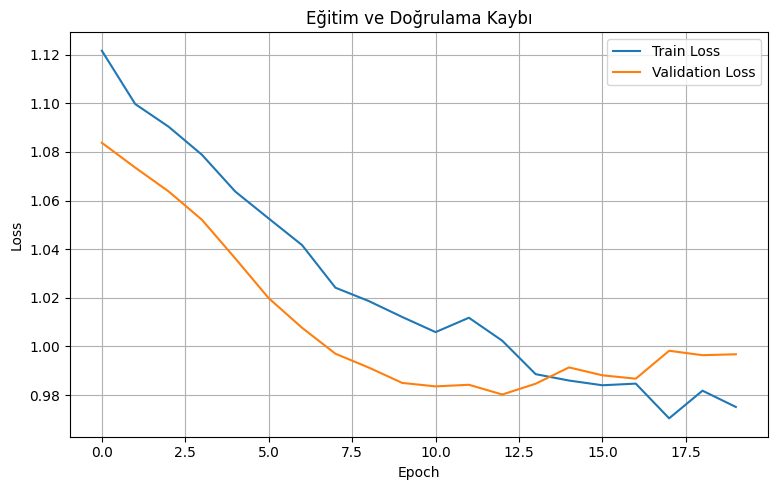

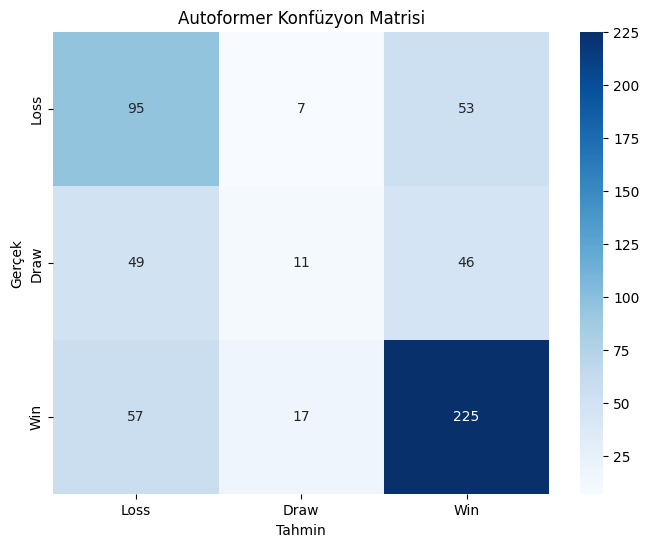



Test Doğruluğu:  0.5910714285714286
Test Kaybı:  1.002456247806549


In [ ]:
EPOCHS = 50
LEARNING_RATE = 0.0005
PATIENCE = 7

# Takım sayısını hesapla
all_team_ids = np.concatenate([df['Takım ID'].values, df['Rakip Takım ID'].values])
num_teams = len(np.unique(all_team_ids))


model = AutoformerClassifier(
    seq_len=20,
    n_features=20,
    d_model=64,
    n_heads=4,
    n_layers=3,
    static_dim=X_static_train.shape[1],
    num_teams=num_teams,
    num_classes=3
).to(device)

# Optimizer ve scheduler
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=0.0002,
                              weight_decay=1e-4)  # L2 regularization
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=3.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

# Sınıf ağırlıklarını hesapla
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Focal Loss'u kullan
criterion = FocalLoss(alpha=class_weights, gamma=3.0)

# Sınıf ağırlıkları
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Eğitim ve doğrulama kayıtları
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_loss = float('inf')
no_improve = 0

# Eğitim süresi ölçümü
total_train_start = time.time()

for epoch in range(EPOCHS):
    start_time = time.time()

    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in train_loader:
        x_seq, x_static, team_ids, opponent_ids, labels = batch
        x_seq, x_static = x_seq.to(device), x_static.to(device)
        team_ids, opponent_ids = team_ids.to(device), opponent_ids.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(x_seq, x_static, team_ids, opponent_ids)

        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = epoch_train_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_acc)


    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in val_loader:
            x_seq, x_static, team_ids, opponent_ids, labels = batch
            x_seq, x_static = x_seq.to(device), x_static.to(device)
            team_ids, opponent_ids = team_ids.to(device), opponent_ids.to(device)
            labels = labels.to(device)

            outputs = model(x_seq, x_static, team_ids, opponent_ids)
            loss = criterion(outputs, labels)

            epoch_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = epoch_val_loss / len(val_loader)
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), 'best_autoformer_model.pth')
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"Erken durdurma!")
            break

    # Zaman
    elapsed = time.time() - start_time

    print(f'Epoch {epoch+1}/{EPOCHS} - {elapsed:.2f}s')
    print(f'Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}')
    print(f'  Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}')
    print('-' * 50)



# En iyi modeli yükle
model.load_state_dict(torch.load('best_autoformer_model.pth'))

model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        x_seq, x_static, team_ids, opponent_ids, labels = batch
        x_seq, x_static = x_seq.to(device), x_static.to(device)
        team_ids, opponent_ids = team_ids.to(device), opponent_ids.to(device)
        labels = labels.to(device)

        outputs = model(x_seq, x_static, team_ids, opponent_ids)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader)
test_acc = correct_test / total_test

print('=' * 50)
print(f'Final Test Performance:')
print(f'Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f}')
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=['Loss', 'Draw', 'Win']))

total_train_time = time.time() - total_train_start
print(f"Toplam eğitim süresi: {total_train_time:.2f} saniye")

# ======== GRAFİKLER ========
plt.figure(figsize=(15, 5))

# Kayıp Grafiği
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.savefig('autoformer_training_metrics.png')
plt.show()

# Konfüzyon Matrisi
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Loss', 'Draw', 'Win'],
            yticklabels=['Loss', 'Draw', 'Win'])
plt.title('Autoformer Konfüzyon Matrisi')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.savefig('autoformer_confusion_matrix.png')
plt.show()

print("\n")
print("Test Doğruluğu: ", test_acc)
print("Test Kaybı: ", test_loss)

Toplam çıkarım süresi: 0.20 saniye
Örnek başına ortalama çıkarım süresi: 0.3568 ms


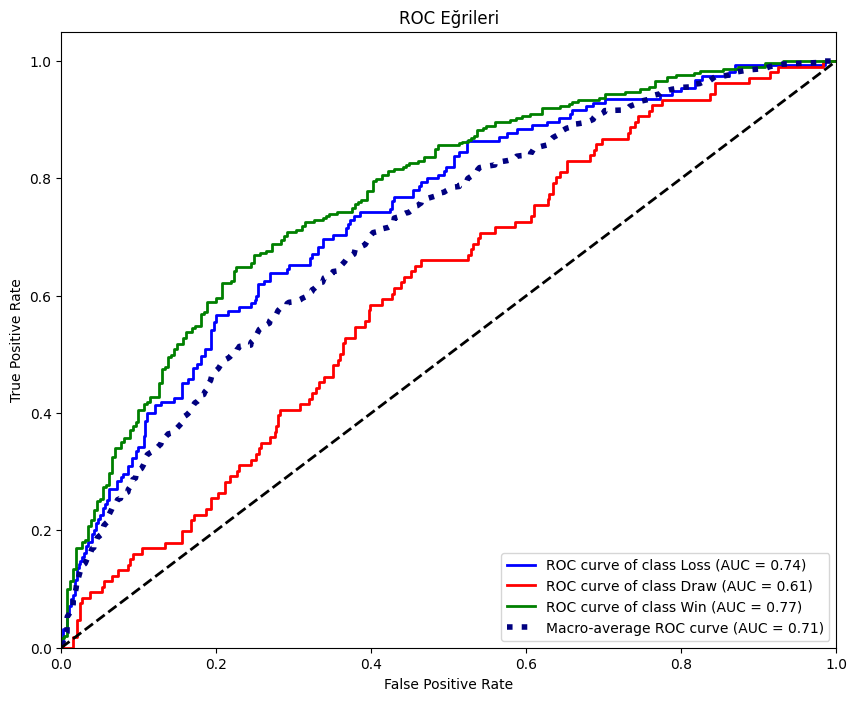


Sınıf Bazında Performans:
Sınıf      Sensitivity  Specificity  AUC       
Loss       0.6129       0.7383       0.7402    
Draw       0.1038       0.9471       0.6071    
Win        0.7525       0.6207       0.7714    

Macro Ortalama:
           0.4897       0.7687       0.7077    


In [ ]:
import torch.nn.functional as F

# Test çıkarım süresi ölçümü
inference_start = time.time()

model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        x_seq, x_static, team_ids, opponent_ids, labels = batch
        x_seq, x_static = x_seq.to(device), x_static.to(device)
        team_ids, opponent_ids = team_ids.to(device), opponent_ids.to(device)
        labels = labels.to(device)

        outputs = model(x_seq, x_static, team_ids, opponent_ids)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_labels.append(labels.cpu())
        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())

inference_time = time.time() - inference_start
print(f"Toplam çıkarım süresi: {inference_time:.2f} saniye")
print(f"Örnek başına ortalama çıkarım süresi: {inference_time/len(test_dataset)*1000:.4f} ms")

# Tensörleri numpy array'e çevir
all_labels = torch.cat(all_labels).numpy()
all_preds = torch.cat(all_preds).numpy()
all_probs = torch.cat(all_probs).numpy()

# Sınıf isimleri
class_names = ['Loss', 'Draw', 'Win']


# 2. ROC Eğrileri ve AUC
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()

# Her sınıf için ROC eğrisi hesapla
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average ROC eğrisi ve AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ROC eğrilerini çiz
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrileri')
plt.legend(loc="lower right")
plt.show()

# 3. Sensitivity (Recall) ve Specificity Hesaplama
sensitivity = {}
specificity = {}

for i, class_name in enumerate(class_names):
    tp = cm[i, i]  # True Positives
    fn = np.sum(cm[i, :]) - tp  # False Negatives
    fp = np.sum(cm[:, i]) - tp  # False Positives
    tn = np.sum(cm) - (tp + fn + fp)  # True Negatives

    sensitivity[class_name] = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity[class_name] = tn / (tn + fp) if (tn + fp) > 0 else 0

# Sonuçları yazdır
print("\nSınıf Bazında Performans:")
print("{:<10} {:<12} {:<12} {:<10}".format('Sınıf', 'Sensitivity', 'Specificity', 'AUC'))
for i, class_name in enumerate(class_names):
    print("{:<10} {:<12.4f} {:<12.4f} {:<10.4f}".format(
        class_name,
        sensitivity[class_name],
        specificity[class_name],
        roc_auc[i]
    ))

# Macro-average hesapla
macro_sensitivity = np.mean(list(sensitivity.values()))
macro_specificity = np.mean(list(specificity.values()))

print("\nMacro Ortalama:")
print("{:<10} {:<12.4f} {:<12.4f} {:<10.4f}".format(
    '',
    macro_sensitivity,
    macro_specificity,
    roc_auc["macro"]
))